In [136]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.style.use('figures.mplstyle')
import leptoninjector as LI
from MuonSimulationHelpers import *
from GeometryHelpers import xyz_to_lat_long

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


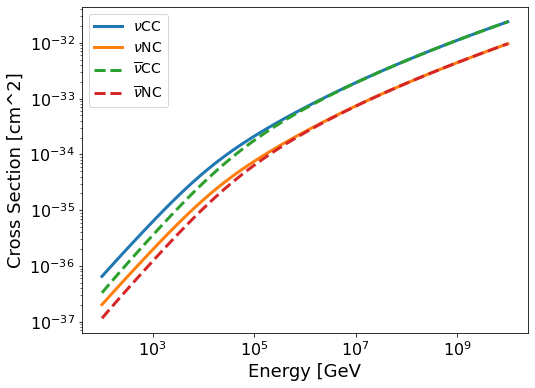

In [2]:
Erange = np.logspace(2,10,100)
for k in DIS_xs:
    if 'bar' in k:
        xs = np.array([DIS_xs[k].TotalCrossSection(numubar,E) for E in Erange])
        plt.plot(Erange,xs,label=r'$\overline{\nu}$' + k[-2:],ls='--')
#         for primary,tag in zip([nuebar,numubar,nutaubar],
#                                [r'$\overline{\nu}_e$',r'$\overline{\nu}_\mu$',r'$\overline{\nu}_\tau$']):
            
#             xs = np.array([DIS_xs[k].TotalCrossSection(primary,E,target_type) for E in Erange])
#             plt.plot(Erange,xs,label=tag + k[-2:],ls='--')
    else:
        xs = np.array([DIS_xs[k].TotalCrossSection(numu,E) for E in Erange])
        plt.plot(Erange,xs,label=r'$\nu$' + k[-2:])
#         for primary,tag in zip([nue,numu,nutau],
#                                [r'$\nu_e$',r'${\nu}_\mu$',r'${\nu}_\tau$']):
            
#             xs = np.array([DIS_xs[k].TotalCrossSection(primary,E,target_type) for E in Erange])
#             plt.plot(Erange,xs,label=tag + k[-2:])
plt.loglog()
plt.legend()
plt.xlabel('Energy [GeV')
plt.ylabel('Cross Section [cm^2]')
plt.show()

In [129]:
light_simulation = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_QGSJET_light_lake_CC.parquet')
charm_simulation = MuonSimulation('Data/MuonSimulation/LHCb_LHC13_BDGJKR_charm_lake_CC.parquet')
Nl = np.sum(light_simulation.data["DIS_distance"]!=0)
Nc = np.sum(charm_simulation.data["DIS_distance"]!=0)
print(Nl,Nc)
N=Nl
print(N)

200000 539518
200000


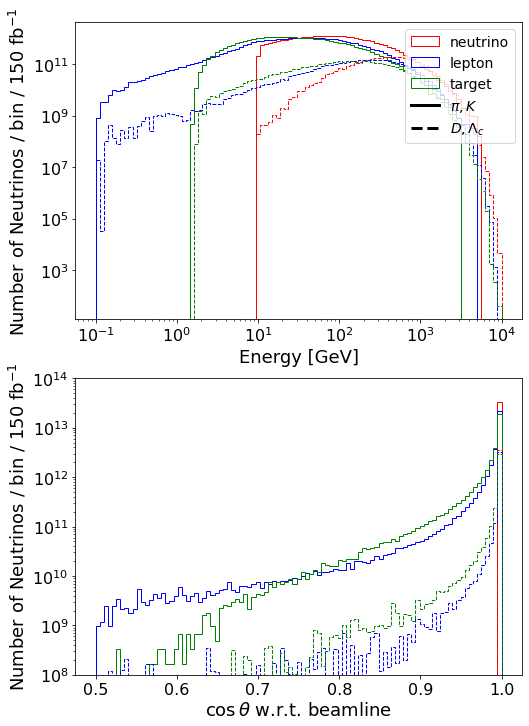

In [8]:
ls_arr = ['solid','dashed']
fig,ax = plt.subplots(2,1,figsize=(8,12))
for i,simulation in enumerate([light_simulation,charm_simulation]):
    
    simulation.EnsureUnitHadDir()
    simulation.EnsureUnitLepDir()
    simulation.EnsureUnitNeutrinoDir()
    
    
    kwargs = {'bins':np.logspace(-1,4,100),
              'histtype':'step',
              'ls':ls_arr[i],
              'weights':simulation.data['wgt']*150*1000}

    ax[0].hist(simulation.data['E'],color='r',label='neutrino' if i==0 else None,**kwargs)
    wnorm = sum(kwargs['weights'])/sum(simulation.data.query('E_lep>0')['wgt']*150*1000)
    kwargs['weights']*=wnorm
    ax[0].hist(simulation.data['E_lep'],color='b',label='lepton' if i==0 else None,**kwargs)
    ax[0].hist(simulation.data['E_had'],color='g',label='target' if i==0 else None,**kwargs)
    
    kwargs = {'bins':np.linspace(0.5,1,100),
              'histtype':'step',
              'ls':ls_arr[i],
              'weights':simulation.data['wgt']*150*1000}
    
    ax[1].hist(simulation.data['uz'],color='r',**kwargs)
    wnorm = sum(kwargs['weights'])/sum(simulation.data.query('E_lep>0')['wgt']*150*1000)
    kwargs['weights']*=wnorm
    ax[1].hist(simulation.data['uz_lep'],color='b',**kwargs)
    ax[1].hist(simulation.data['uz_had'],color='g',**kwargs)

ax[0].plot([],[],color='black',label=r'$\pi,K$')
ax[0].plot([],[],color='black',ls='--',label=r'$D,\Lambda_c$')
ax[0].set_xlabel('Energy [GeV]')
ax[0].set_ylabel(r'Number of Neutrinos / bin / 150 fb$^{-1}$')
ax[0].loglog()
ax[0].legend()

ax[1].set_xlabel(r'$\cos\theta$ w.r.t. beamline')
ax[1].set_ylabel(r'Number of Neutrinos / bin / 150 fb$^{-1}$')
ax[1].set_ylim(1e8,1e14)
ax[1].semilogy()

plt.show()

18210.36420728398
6.292559636631747 46.33426874901515


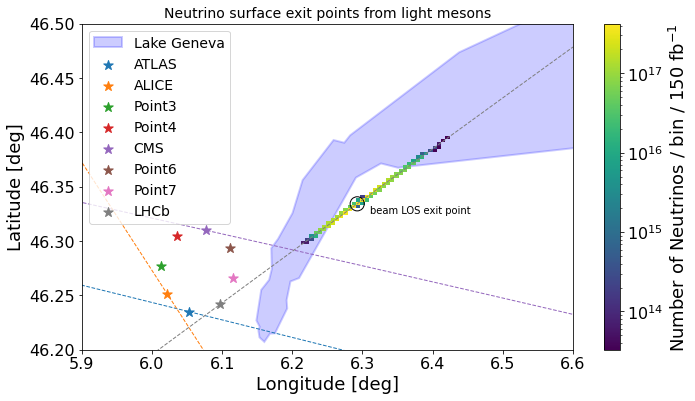

18210.36420728398
6.292559636631747 46.33426874901515


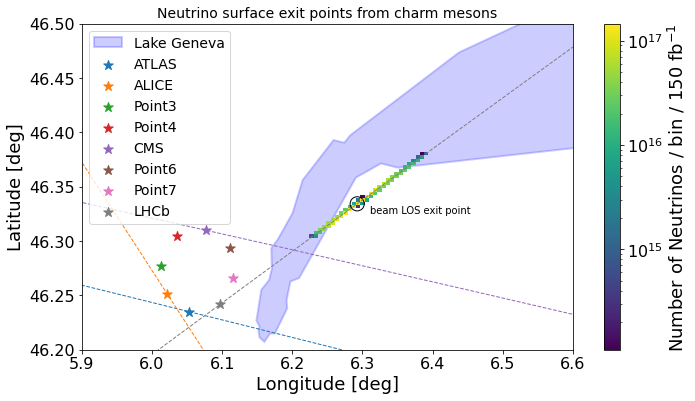

In [9]:
for simulation,tag in zip([light_simulation,charm_simulation],
                          ['light','charm']):
    fig = plt.figure(figsize=(11,6))
    plt.fill(list(Lake_data['Longitude']) + [Lake_data['Longitude'][0]],
             list(Lake_data['Latitude']) + [Lake_data['Latitude'][0]],
             color='blue',label='Lake Geneva',alpha=0.2,linewidth=2)
    for k,color in zip(list(LHC_data.index),mcolors.TABLEAU_COLORS):
        lines = plot_tangent_line_lat_long(LHC,
                                           np.array(LHC_data.loc[k,['X','Y','Z']]),
                                           np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                           limit=1 if 'Point' in k else 60000)
        center, earth_points = lines[0] # all lines are essentially the same
        plt.plot([p[1] for p in earth_points],
                [p[0] for p in earth_points],color=color,ls='--',lw=1)
        plt.scatter(center[1],
                    center[0],
                    marker='*',color=color,label=k)
        if 'Point' in k: continue # don't consider points without collisions
        int1,int2 = calculate_intersections_with_lake(LHC,
                                                    np.array(LHC_data.loc[k,['X','Y','Z']]),
                                                    np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                                    np.array(Lake_data[['Latitude','Longitude']]),
                                                    limit=50000000)
    plt.xlabel('Longitude [deg]')
    plt.ylabel('Latitude [deg]')
    plt.legend(loc='upper left')
    plt.title('Neutrino surface exit points from %s mesons'%tag,fontsize=14)
    plt.hist2d([x[1] for x in simulation.data['surface_intersection_lat_long']],
               [x[0] for x in simulation.data['surface_intersection_lat_long']],
               bins=(np.linspace(6.0,6.6,100),np.linspace(46.2,46.5,100)),
               weights = (simulation.data['wgt']*150*1000)*len(simulation.data),
               norm=matplotlib.colors.LogNorm())
    c = plt.colorbar()
    c.set_label(r'Number of Neutrinos / bin / 150 fb$^{-1}$')
    simulation.CalculateBeamExitPointFromIP('LHCb')
    print(np.linalg.norm(simulation.beam_exit_point-np.array(LHC_data.loc["LHCb",['X','Y','Z']])))
    print(simulation.beam_exit_point_lat_long[1],simulation.beam_exit_point_lat_long[0])
    plt.scatter(simulation.beam_exit_point_lat_long[1],simulation.beam_exit_point_lat_long[0],marker='o',facecolors='none',edgecolors='black',s=200)
    plt.text(1.003*simulation.beam_exit_point_lat_long[1],0.9998*simulation.beam_exit_point_lat_long[0],'beam LOS exit point')
    plt.xlim(5.9,6.6)
    plt.ylim(46.2,46.5)
    plt.show()


/Users/nickkamp/Documents/Harvard/Research/Geneva/Lake_Geneva_Neutrinos/GeometryHelpers.py:211: RuntimeWarning: invalid value encountered in scalar divide
  lat = math.degrees(np.arcsin(z/R))


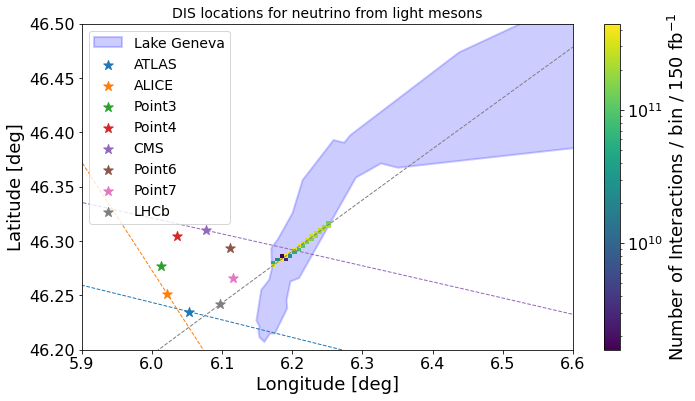

/Users/nickkamp/Documents/Harvard/Research/Geneva/Lake_Geneva_Neutrinos/GeometryHelpers.py:211: RuntimeWarning: invalid value encountered in scalar divide
  lat = math.degrees(np.arcsin(z/R))


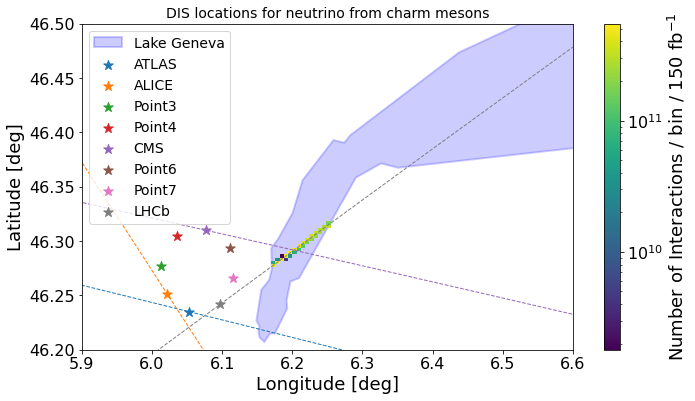

In [10]:
for simulation,tag in zip([light_simulation,charm_simulation],
                          ['light','charm']):
    fig = plt.figure(figsize=(11,6))
    plt.fill(list(Lake_data['Longitude']) + [Lake_data['Longitude'][0]],
             list(Lake_data['Latitude']) + [Lake_data['Latitude'][0]],
             color='blue',label='Lake Geneva',alpha=0.2,linewidth=2)
    for k,color in zip(list(LHC_data.index),mcolors.TABLEAU_COLORS):
        lines = plot_tangent_line_lat_long(LHC,
                                           np.array(LHC_data.loc[k,['X','Y','Z']]),
                                           np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                           limit=1 if 'Point' in k else 60000)
        center, earth_points = lines[0] # all lines are essentially the same
        plt.plot([p[1] for p in earth_points],
                [p[0] for p in earth_points],color=color,ls='--',lw=1)
        plt.scatter(center[1],
                    center[0],
                    marker='*',color=color,label=k)
        if 'Point' in k: continue # don't consider points without collisions
        int1,int2 = calculate_intersections_with_lake(LHC,
                                                    np.array(LHC_data.loc[k,['X','Y','Z']]),
                                                    np.array(LHC_data.loc[k,['CrossingOrientation','CrossingAngle']]),
                                                    np.array(Lake_data[['Latitude','Longitude']]),
                                                    limit=50000000)
    plt.xlabel('Longitude [deg]')
    plt.ylabel('Latitude [deg]')
    plt.legend(loc='upper left')
    plt.title('DIS locations for neutrino from %s mesons'%tag,fontsize=14)
    plt.hist2d([xyz_to_lat_long(*x)[1] for x in simulation.data['DIS_location']],
               [xyz_to_lat_long(*x)[0] for x in simulation.data['DIS_location']],
               bins=(np.linspace(6.0,6.6,100),np.linspace(46.2,46.5,100)),
               weights = (simulation.data['interaction_probability']*simulation.data['wgt']*150*1000)*len(simulation.data),
               norm=matplotlib.colors.LogNorm())
    c = plt.colorbar()
    c.set_label(r'Number of Interactions / bin / 150 fb$^{-1}$')
    plt.xlim(5.9,6.6)
    plt.ylim(46.2,46.5)
    plt.show()

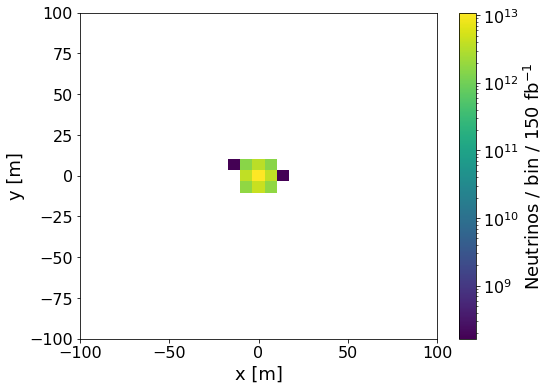

[0. 0. 0. ... 0. 0. 0.]
0.0
0.0
0.0


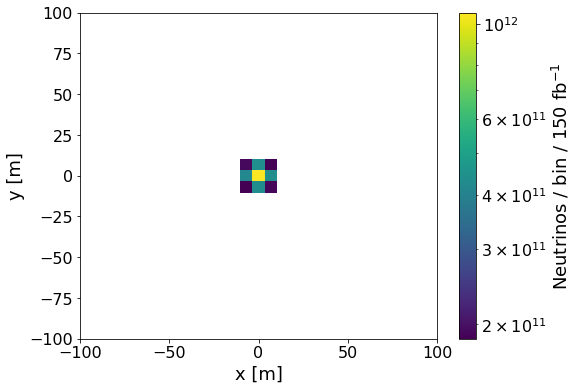

[0. 0. 0. ... 0. 0. 0.]
0.0
0.0
0.0


In [13]:
for simulation in [light_simulation,charm_simulation]:
    plt.hist2d(simulation.data['nu_transverse_profile_x'],
               simulation.data['nu_transverse_profile_y'],
               weights=simulation.data['nu_weight'],
               bins=np.linspace(-100,100,30),norm=matplotlib.colors.LogNorm())
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    c = plt.colorbar()
    c.set_label(r'Neutrinos / bin / 150 fb$^{-1}$')
    plt.show()
    
    mu_weights = np.array(simulation.data['muon_weights'])
    mu_detector_distances = np.array(simulation.data['muon_lengths'])
    mu_surface_distances = np.array(simulation.data['lepton_surface_distances'])
    mu_distances = np.array([min(x,y) for x,y in zip(mu_detector_distances,mu_surface_distances)])
    mu_profile = np.array([simulation.data['muon_transverse_profile_x'],
                           simulation.data['muon_transverse_profile_y']]).T
    
    def Xf(E,rho=1):
        return 1./(rho * 5e-4) * np.log(1 + 2e-3 * E)
    mu_ranges = Xf(simulation.data["E_lep"],rho=2.7)

    mu_weights *= mu_distances<mu_ranges
    mu_radius = np.sqrt(np.sum(mu_profile**2,axis=-1))
    for rad_cut in [5,10,15]:
        fid_weights = (mu_weights * (mu_radius<rad_cut))
        print(sum(fid_weights))

#     plt.hist2d(mu_profile[:,0],mu_profile[:,1],weights=mu_weights,bins=np.linspace(-100,100,30),norm=matplotlib.colors.LogNorm())
#     plt.xlabel('x [m]')
#     plt.ylabel('y [m]')
#     c = plt.colorbar()
#     c.set_label(r'Muons / bin / 150 fb$^{-1}$')
#     plt.show()

#     plt.hist2d(mu_profile[:,0],mu_profile[:,1],weights=fid_weights,bins=np.linspace(-100,100,30),norm=matplotlib.colors.LogNorm())
#     plt.xlabel('x [m]')
#     plt.ylabel('y [m]')
#     c = plt.colorbar()
#     c.set_label(r'Muons / bin / 150 fb$^{-1}$')
#     plt.show()

#     plt.hist(simulation.data["DIS_distance"],weights=fid_weights,bins=np.linspace(10000,20000,50))
#     plt.xlabel('DIS distance [m]')
#     plt.ylabel(r'Muons / bin / 150 fb$^{-1}$')
#     plt.show()

#     plt.hist(mu_distances,bins=np.linspace(0,2000,50),weights=mu_weights)
#     plt.xlabel('Muon Propagation Distance [m]')
#     plt.ylabel(r'Muons / bin / 150 fb$^{-1}$')
#     plt.show()

12922


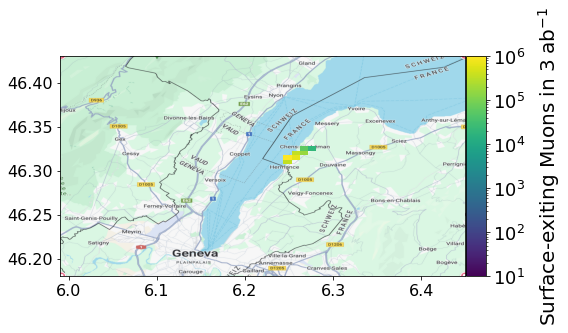

34874


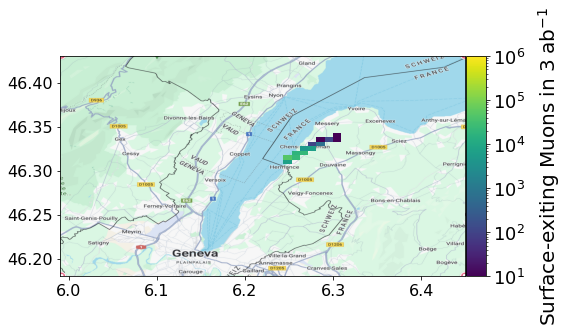

In [156]:
length_cut = 500
rad_cut = 5
detector_center = 14000

def Xf(E,rho=1):
        return 1./(rho * 5e-4) * np.log(1 + 2e-3 * E)
    
for i,simulation in enumerate([light_simulation,charm_simulation]):
    lat_edges = [46.18,46.43]
    lon_edges = [5.99,6.45]
    muon_mask = abs(simulation.data["PDG"])==14
    muon_exits = np.array(list(simulation.data["lepton_surface_intersection_lat_long"][muon_mask]))
    nbins = 50
    nu_weights = np.array(simulation.data['nu_weight']*simulation.data['interaction_probability'])*20 # 3 ab^-1
    beamline_dist = np.array(simulation.data['DIS_distance']*simulation.data['uz'])
    nu_profile = np.array([simulation.data['DIS_distance']*simulation.data['ux'],
                           simulation.data['DIS_distance']*simulation.data['uy']]).T
    nu_radius = np.sqrt(np.sum(nu_profile**2,axis=-1))
    nu_weights *= (np.logical_and(beamline_dist<(detector_center+(length_cut/2)),
                                  beamline_dist>(detector_center-(length_cut/2))))
    print(sum(nu_weights!=0))
    nu_weights *= nu_radius < rad_cut
    mu_distance = np.linalg.norm(np.array(list(simulation.data["lepton_surface_intersection"]-simulation.data["DIS_location"])),axis=-1)
    nu_weights *= mu_distance < Xf(simulation.data["E"])
    h = plt.hist2d(muon_exits[:,1],muon_exits[:,0],
                   bins=(np.linspace(*lon_edges,nbins),np.linspace(*lat_edges,nbins)),
                   norm=mcolors.LogNorm(vmin=1e1,vmax=1e6),
                   weights=nu_weights[muon_mask])
    
    img = plt.imread("Figures/GoogleMaps.png")
    plt.imshow(img,extent=[5.99,6.45,46.18,46.43],aspect=1)
    plt.xlim(*lon_edges)
    plt.ylim(*lat_edges)
    
    
    # create an axes on the right side of ax. The width of cax will be 5%
    # of ax and the padding between cax and ax will be fixed at 0.05 inch.
    divider = make_axes_locatable(plt.gca())
    cax = divider.append_axes("right", size="5%", pad=0.01)
    cbar = plt.colorbar(h[3],cax=cax)
    cbar.ax.tick_params(labelsize=18)  # set your label size here
    cbar.set_label(r"Surface-exiting Muons in $3\;{\rm ab}^{-1}$",fontsize=20,labelpad=10)
    plt.tight_layout()
    plt.savefig("Figures/MuonSurfaceExitFromLakeDetector_%s.pdf"%("light" if i==0 else "charm"),dpi=100)
    
    plt.show()

In [54]:
light_simulation.data["lake_intersection1"]

0         [4374357.104740651, 479404.33985561866, 460753...
1         [4374413.654522465, 479336.59465545847, 460748...
2         [4374426.390830535, 479335.0560985067, 4607499...
3         [4374356.457280173, 479398.5218866647, 4607541...
4         [4374355.119094943, 479399.1680033186, 4607538...
                                ...                        
199995    [4374361.825349225, 479406.3660028266, 4607532...
199996    [4374351.596348547, 479397.67602797004, 460753...
199997    [4374368.760889693, 479408.85277608765, 460753...
199998    [4374425.827441194, 479336.5491372738, 4607496...
199999    [4374420.562873516, 479337.858846361, 4607486....
Name: lake_intersection1, Length: 200000, dtype: object

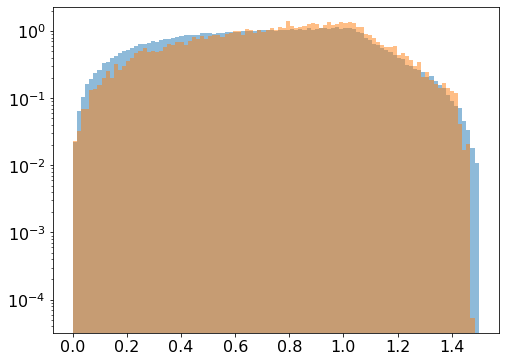

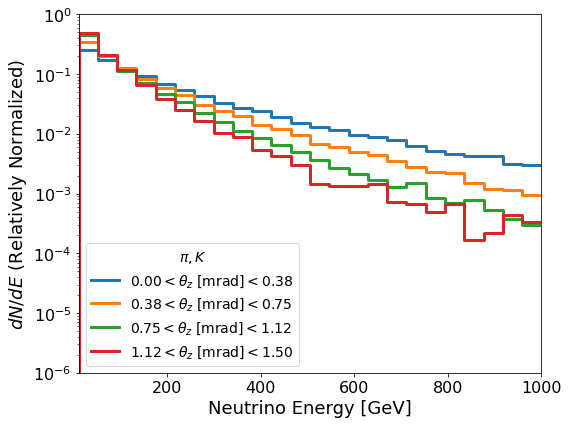

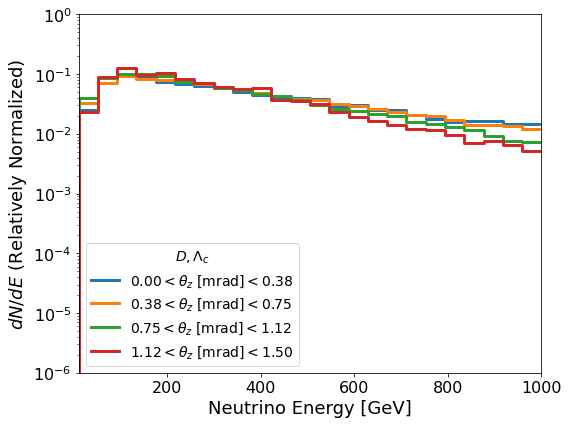

In [200]:
angle_bins = np.linspace(0,1.5,100)
angle_bins_coarse = np.linspace(0,1.5,5)
ebins = np.linspace(1e1,1e3,25)
ebinwidth = ebins[1:] - ebins[:-1]

for simulation in [light_simulation,charm_simulation]:
    angle = np.arccos(simulation.data["uz"])*1e3 # mrad
    plt.hist(angle,bins=angle_bins,alpha=0.5,weights=simulation.data["wgt"],density=True)
plt.semilogy()
plt.show()

for i,simulation in enumerate([light_simulation,charm_simulation]):
    angle = np.arccos(simulation.data["uz"])*1e3 # mrad
    for angle_low,angle_high in zip(angle_bins_coarse[:-1],angle_bins_coarse[1:]):
        angle_filter = np.logical_and(angle>angle_low,angle<angle_high)
        n,_ = np.histogram(simulation.data["E"],bins=ebins,weights=angle_filter*simulation.data["wgt"])
        y = n/ebinwidth
        y /= sum(y)
        plt.step(ebins,np.append([0],y),lw=3,label=r"$%2.2f < \theta_z\;[{\rm mrad}] < %2.2f$"%(angle_low,angle_high))
    plt.semilogy()
    plt.legend(title=r"$\pi,K$" if i==0 else r"$D,\Lambda_c$")
    plt.ylim(1e-6,1)
    plt.xlabel("Neutrino Energy [GeV]")
    plt.ylabel(r"$dN/dE$ (Relatively Normalized)")
    plt.xlim(ebins[0],ebins[-1])
    plt.tight_layout()
    plt.savefig("Figures/OffAxisFlux_%s.pdf"%("light" if i==0 else "charm"),dpi=100)
    plt.show()
        